In [1]:
import numpy as np
import torch
import tensorflow as tf
import gym
import sys
from collections import deque
import random

from explorerl.agents import BaseAgent
from explorerl.utils import *

## Tensorflow

In [2]:
class DualPolicyValueHeadTf(tf.keras.Model):
    def __init__(self,input_space,output_space,configs={}):
        super(DualPolicyValueHeadTf, self).__init__()
        value = []
        #value head
        value.append(create_linear_tf(input_dims=input_space,output_dims=32,relu=True))
        value.append(create_linear_tf(input_dims=(32,),output_dims=1,relu=False))
        self.valuehead = tf.keras.models.Sequential(value)
        #policy head
        policy = []
        policy.append(create_linear_tf(input_dims=input_space,output_dims=32,relu=True))
        policy.append(create_linear_tf(input_dims=(32,),output_dims=output_space,relu=False))
        self.policyhead = tf.keras.models.Sequential(policy)        
        if "softmax" in configs:
            self.policyhead = tf.keras.models.Sequential([self.policyhead,tf.keras.layers.Softmax()])
            
    def call(self,x,training=True):
        value = self.valuehead(x)
        policy = self.policyhead(x)
        return value, policy


In [3]:
class ActorCriticTf(BaseTfAgent):
    def __init__(self,estimator=None,gamma=0.995,learning_rate=0.001, featurizer=None,
                scaler=None,configs={"softmax"},replay_size=500,replay_batch=32):
        super(ActorCriticTf, self).__init__(estimator,gamma,learning_rate,featurizer,scaler,configs,replay_size=replay_size)
        self.name = "ActorCriticTf"
        self.replay_batch = replay_batch
    
    def initialize_model(self,observation_space,action_space):
        super(ActorCriticTf, self).initialize_model(observation_space,action_space)          

        def log_loss(model,predictions,targets):
            return -1*(tf.reduce_sum(tf.multiply(tf.math.log(predictions),targets)))
        
        def value_loss_fn(model,predictions,targets):
            return tf.reduce_sum(tf.square(tf.subtract(targets,predictions)))
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        def train_step(model,inputs,action,value_target,advantage_target):
            with tf.GradientTape() as tape:
                value,predictions = model(inputs)
                value_loss = value_loss_fn(model.valuehead,value,value_target)
                policy_loss = log_loss(model.policyhead,predictions,advantage_target)
                loss = value_loss + policy_loss
            policy_gradients = tape.gradient(loss,model.trainable_variables)
            optimizer.apply_gradients(zip(policy_gradients,model.trainable_variables))
            del tape
                
        self.model["loss"] = log_loss
        self.model["training_op"] = train_step
        print("Model Created!")

    def train_policy(self):
        return self.stochastic()
    
    def test_policy(self):
        return self.stochastic()
    
    def stochastic(self):
        def act(obs):
            estimator = self.model["estimator"]
            _, probs = estimator(obs)
            if "continuous" not in self.configs:
                return np.random.choice(self.action_space,p=np.array(probs[0])) , probs
        return act
    
    def greedy(self):
        def act(obs):
            estimator = self.model["estimator"]
            probs = estimator(obs)
            return np.argmax(probs[0]) , probs
        return act
    
    def replay(self,policy):
        training_op = self.model["training_op"]
        for obs, action, next_obs, reward, done in self.experience_replay:
            value = self.model["estimator"].valuehead(obs)
            next_value = self.model["estimator"].valuehead(next_obs)
            target = reward
            if done == False:
                target += self.gamma*next_value
            value_target = tf.stop_gradient(target)
            advantage_target = np.zeros((1,self.action_space))
            advantage_target[0][action] = tf.stop_gradient(target - value)
            training_op(self.model["estimator"],obs,action,value_target,advantage_target)
        
            
    def episodal_train_iter(self,policy):
        #has experience memory, but only updates 
        self.replay(policy)
        self.experience_replay = deque(maxlen=self.replay_size)
    
    def train_iter(self,policy,action,values,obs,next_obs,reward,done):
        training_op = self.model["training_op"]
        value = self.model["estimator"].valuehead(obs)
        next_value = self.model["estimator"].valuehead(next_obs)
        target = reward
        if done == False:
            target += self.gamma*next_value
        value_target = tf.stop_gradient(target)
        advantage_target = np.zeros((1,self.action_space))
        advantage_target[0][action] = tf.stop_gradient(target - value)
        training_op(self.model["estimator"],obs,action,value_target,advantage_target)


In [4]:
env = gym.make("CartPole-v0")
e = EnvRunner(env)

In [5]:
a = ActorCriticTf(estimator=DualPolicyValueHeadTf,learning_rate=0.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

Model Created!


Epsilon : None, Num Steps : 12, Avg Reward with Window Size 100 : 148.76: 100%|██████████| 1000/1000 [15:24<00:00,  1.08it/s]          
/Users/shyam/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/shyam/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


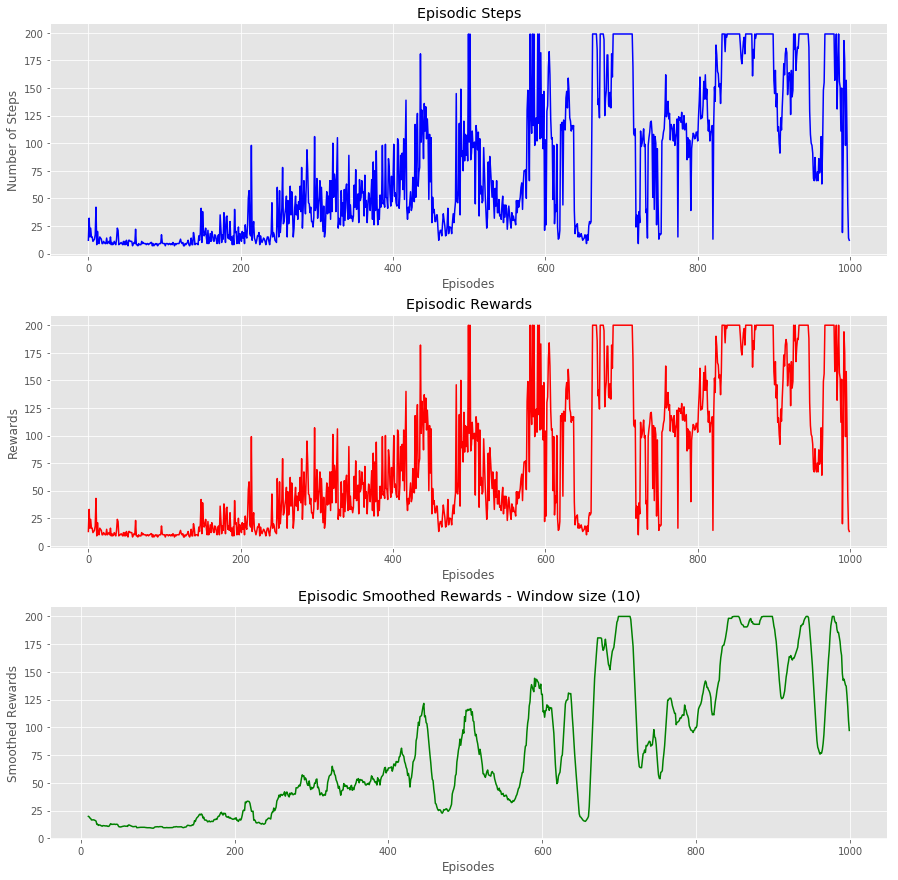

In [6]:
stats = e.train(a,episodes=1000,train_episodal=False)

Total reward for episode 0: -106.31063861868584



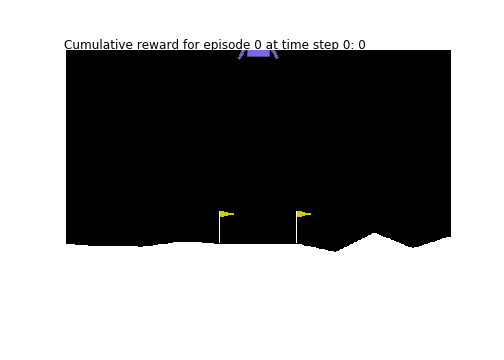
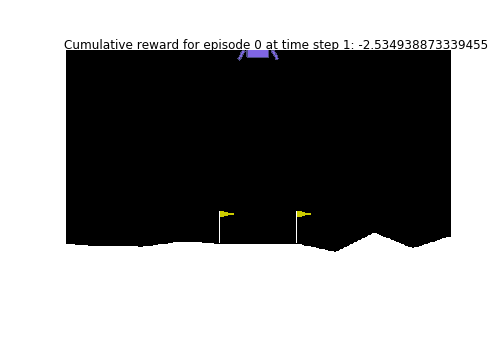
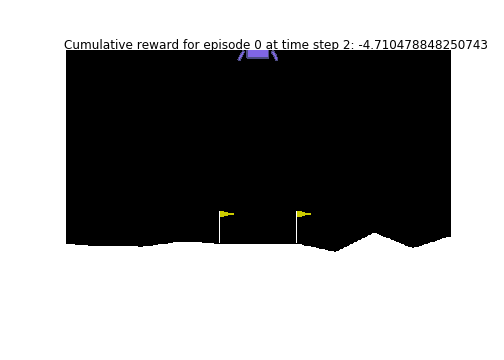
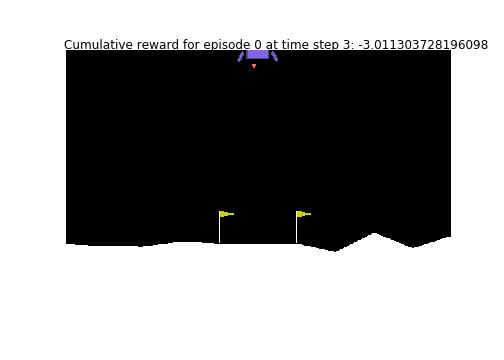
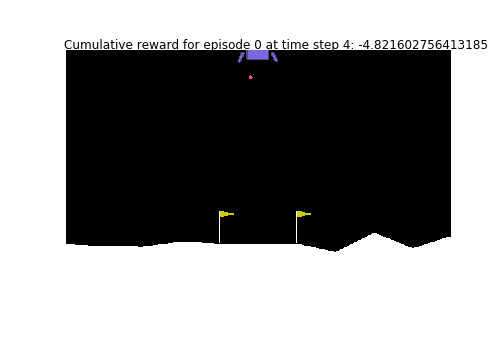
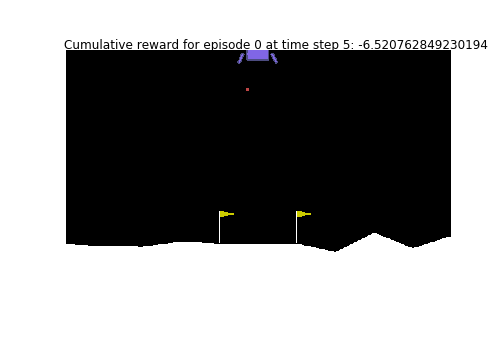
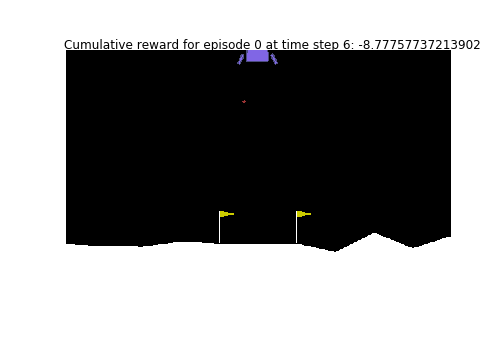
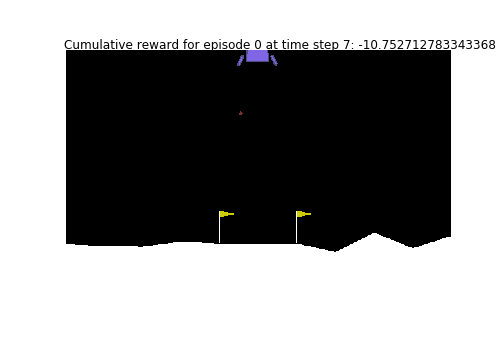
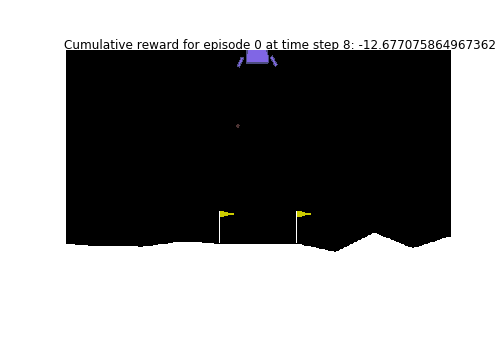
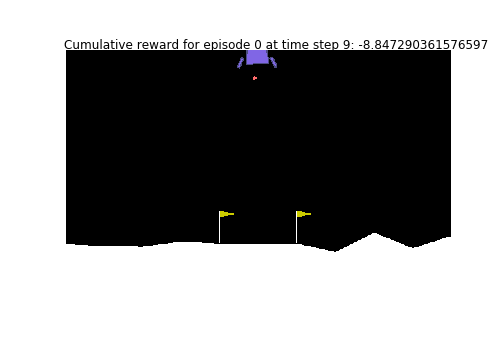
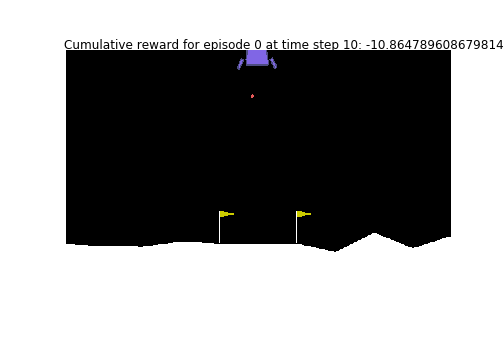
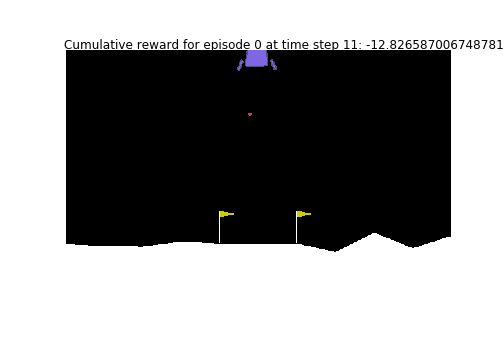
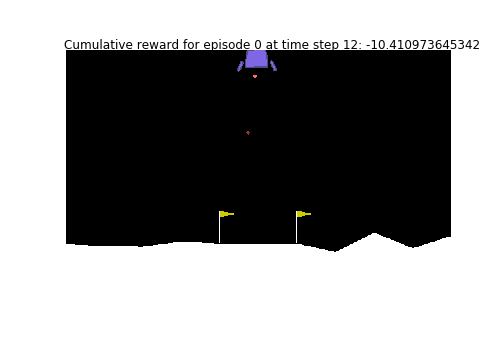
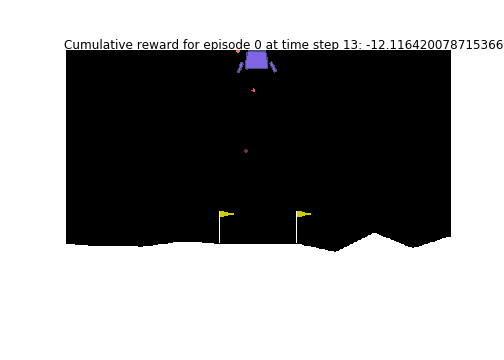
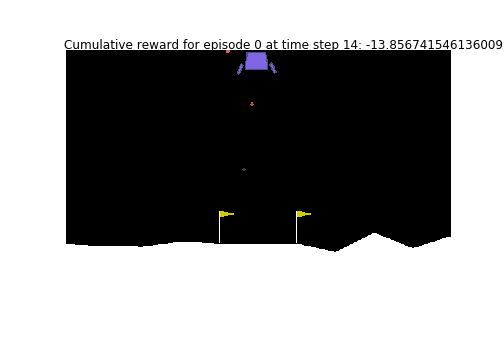
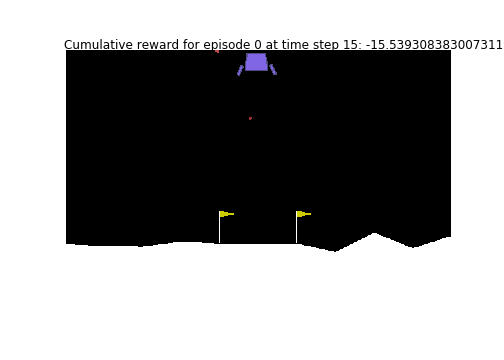
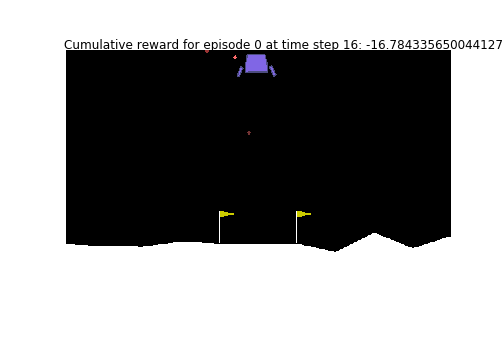
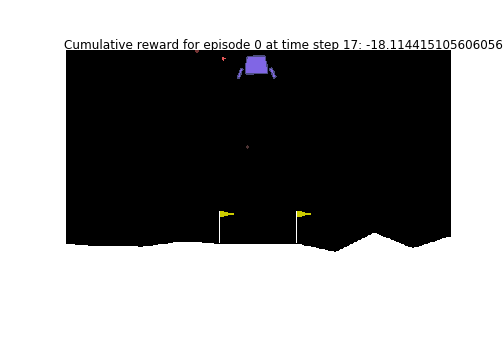
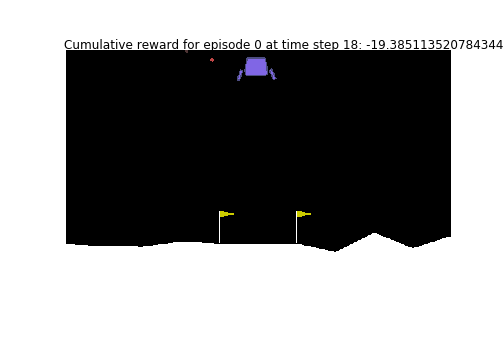
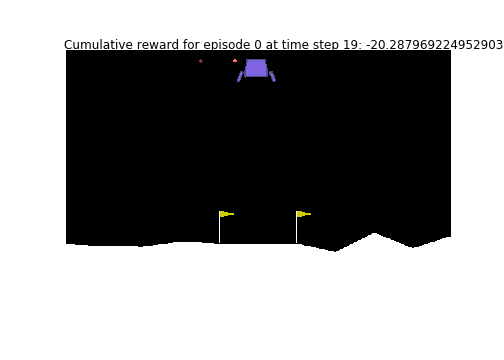
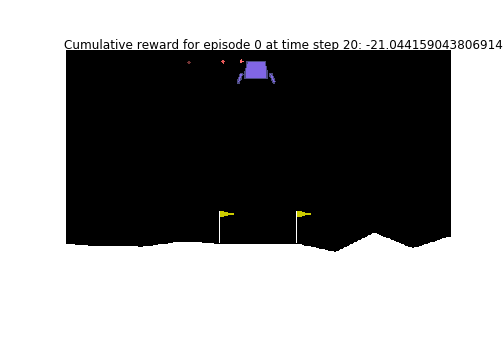
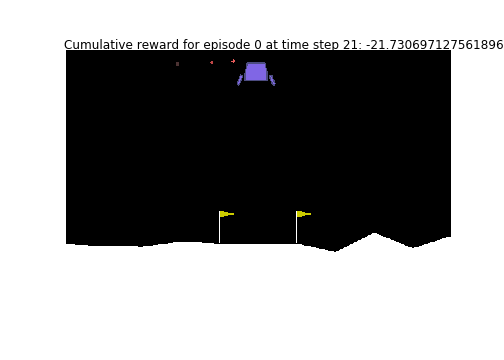
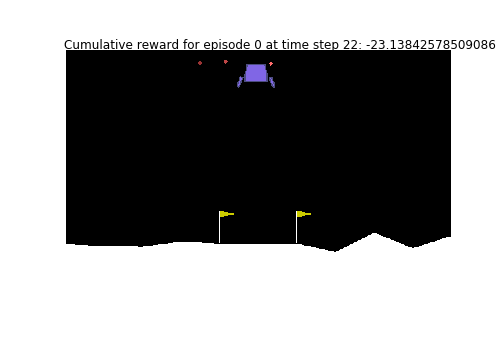
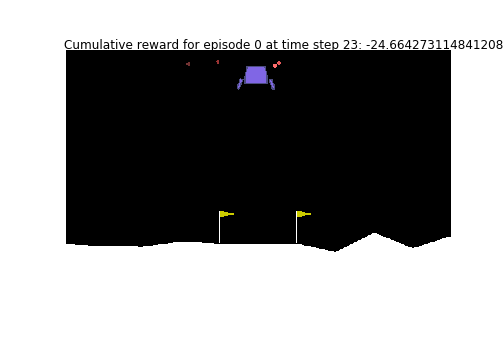
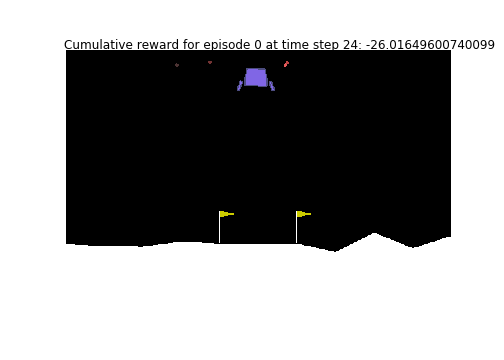
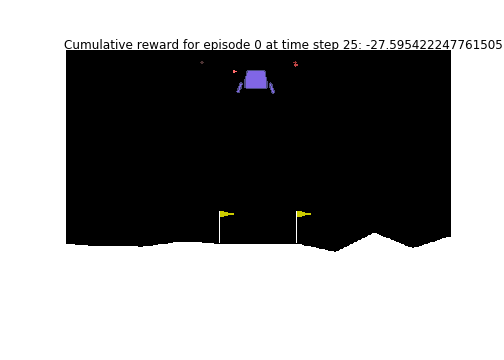
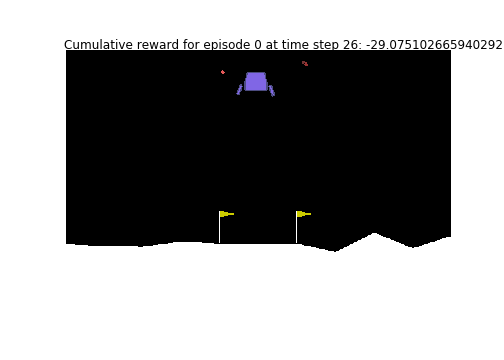
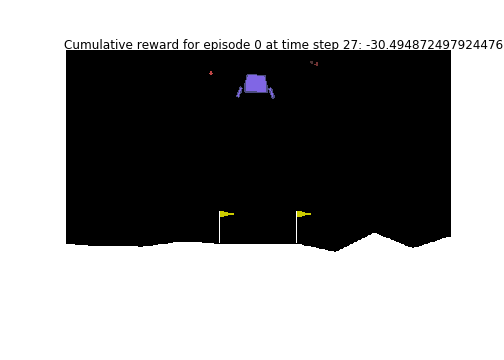
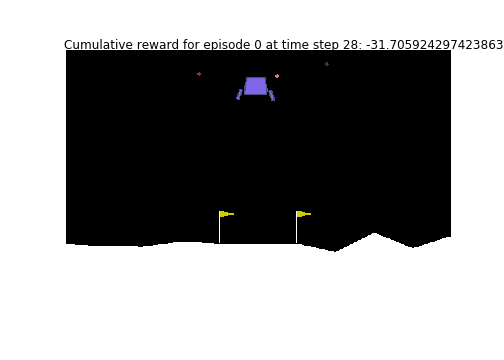
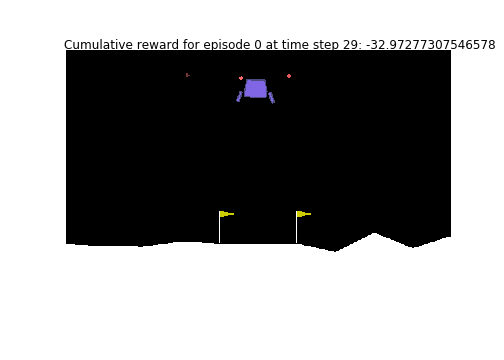
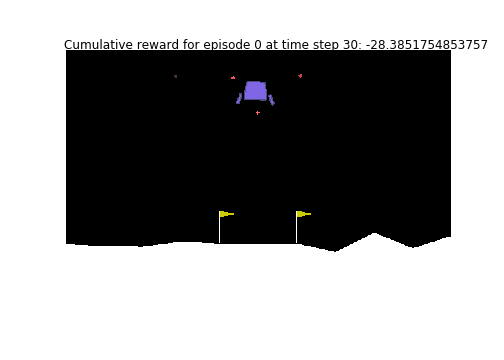
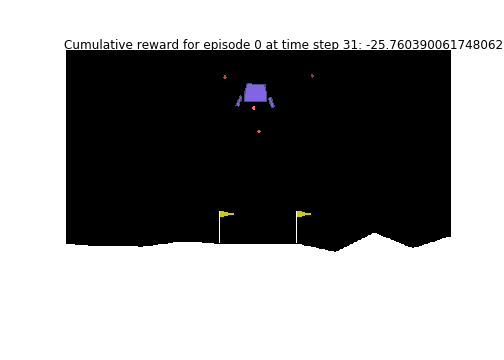
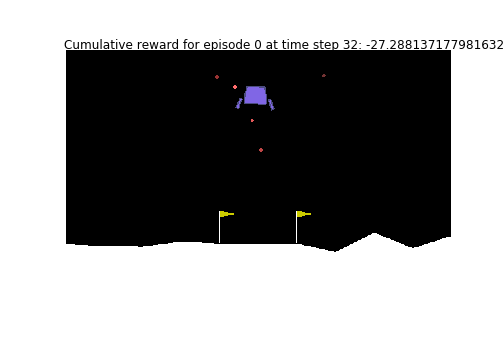
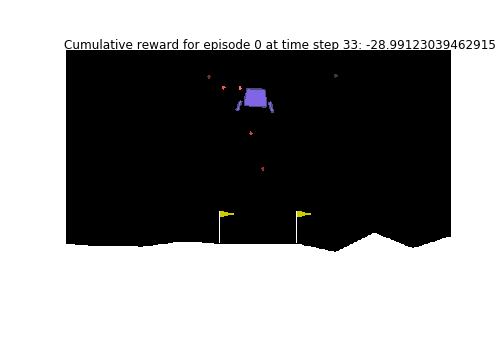
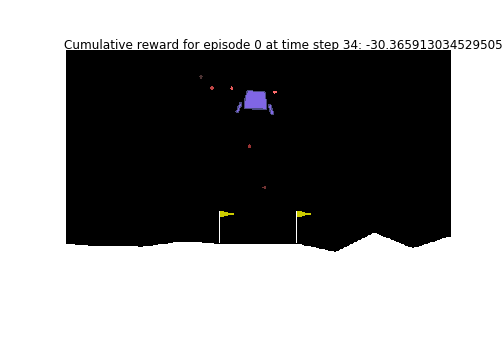
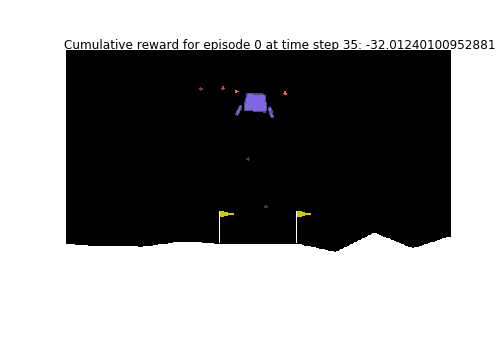
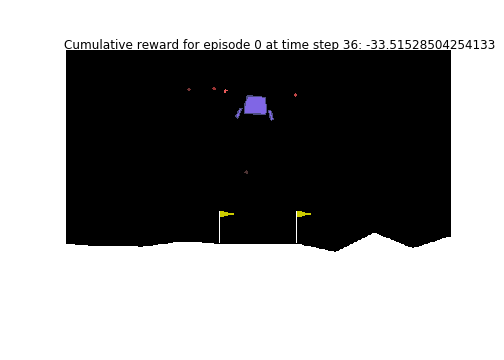
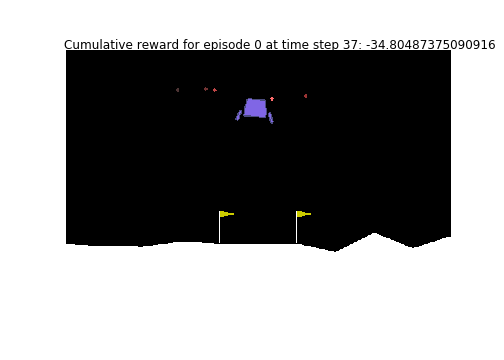
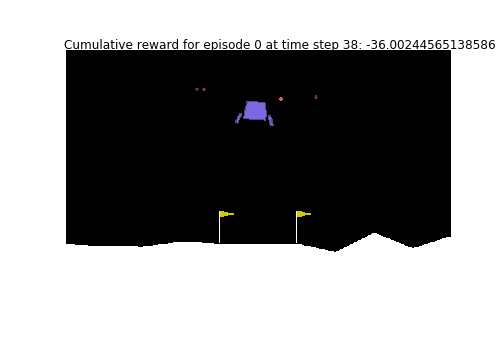
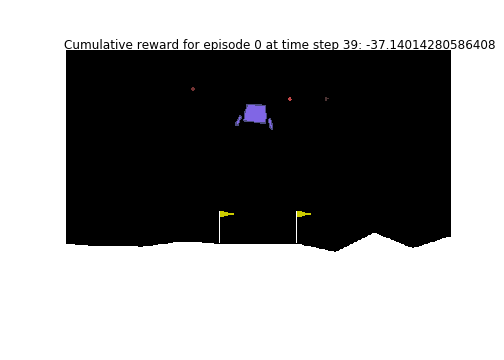
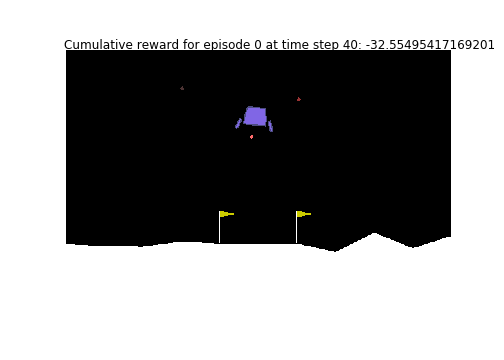
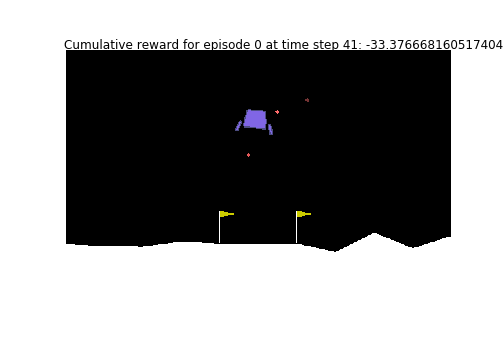
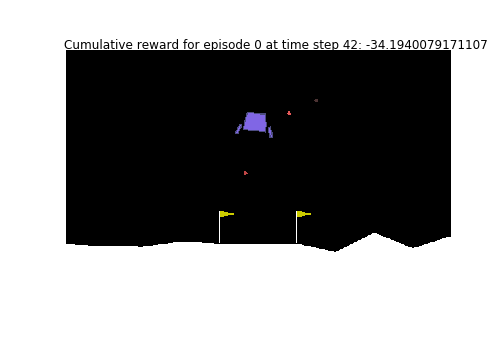
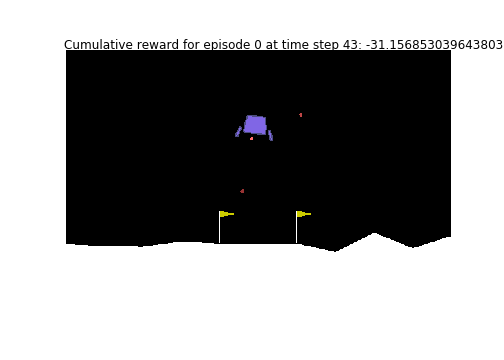
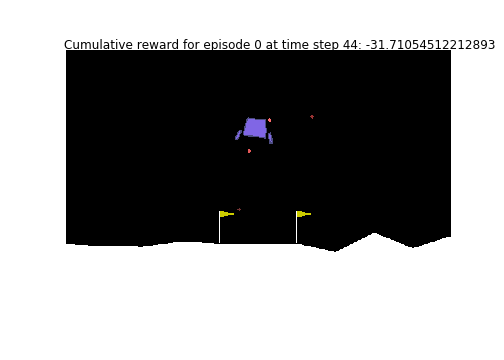
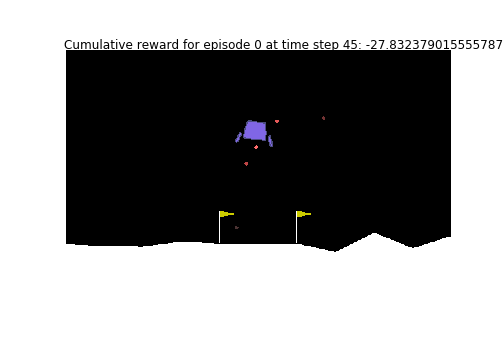
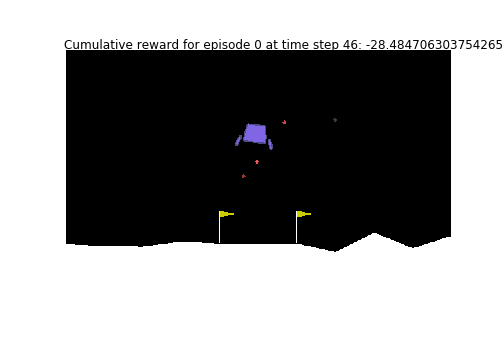
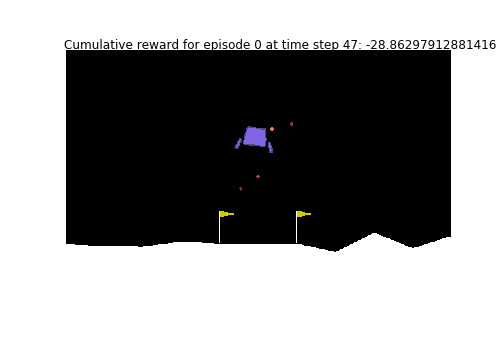
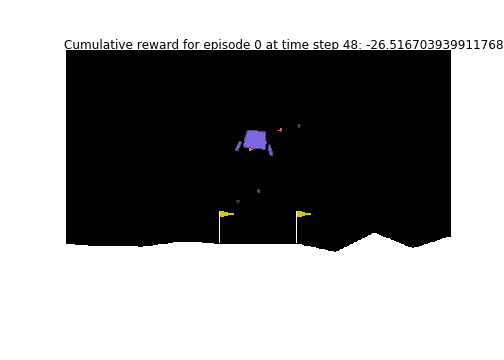
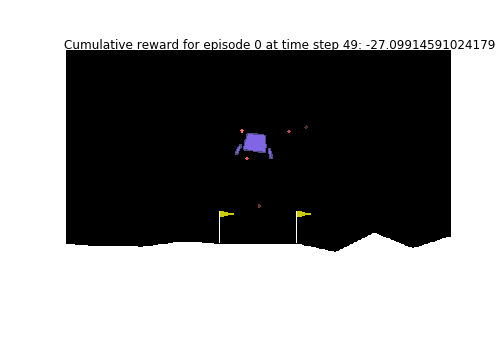
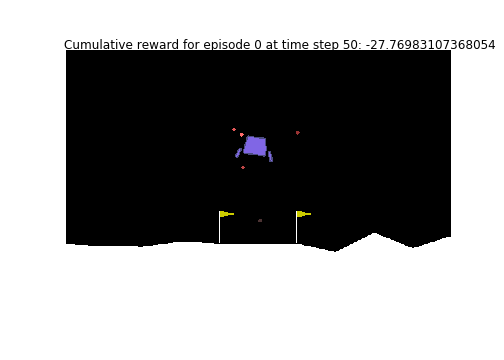
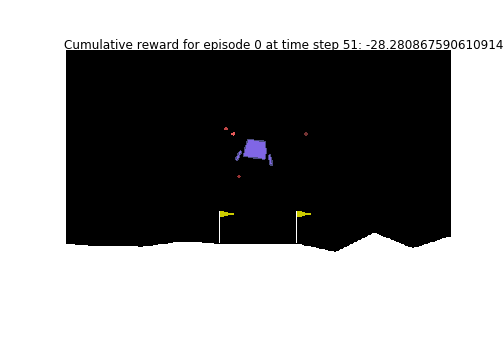
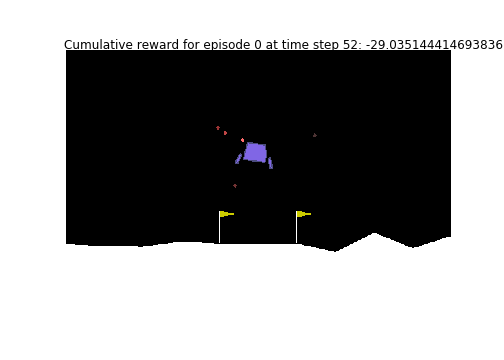
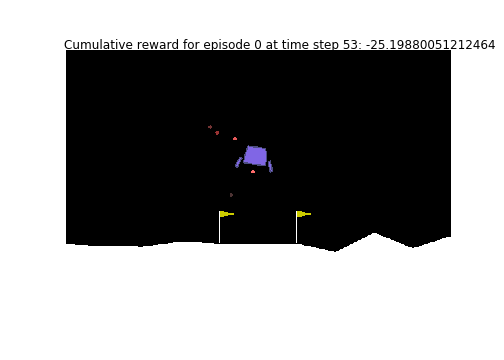
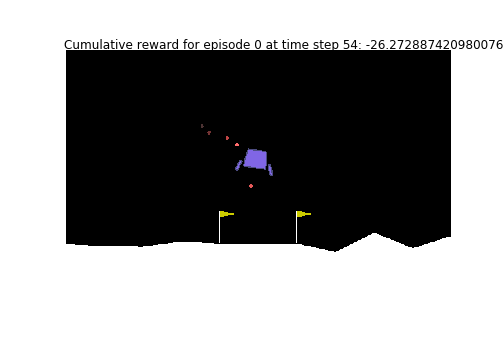
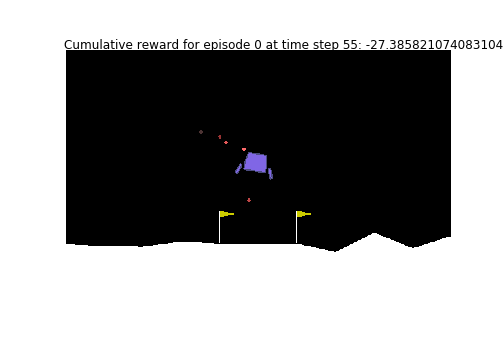
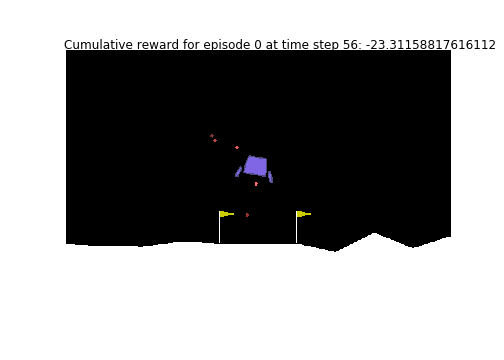
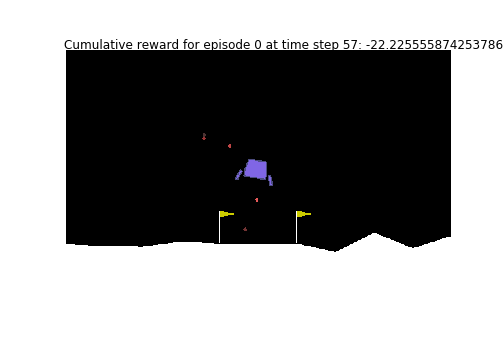
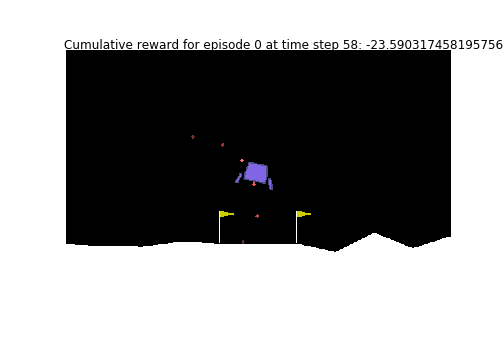
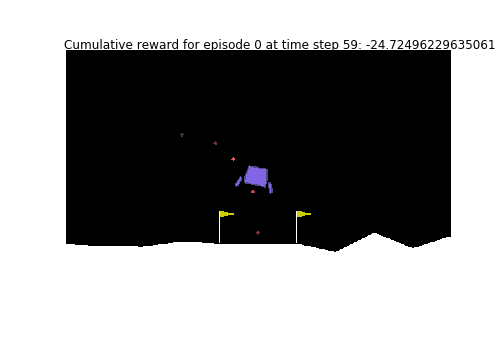
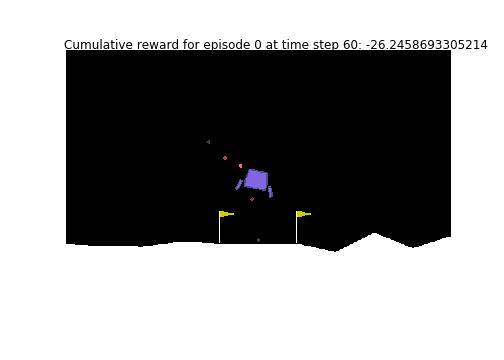
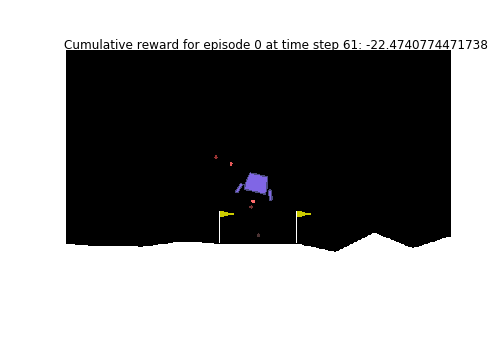
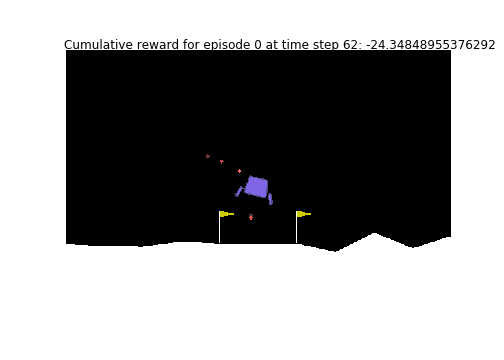
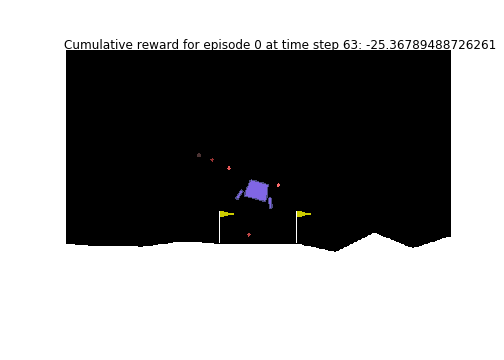
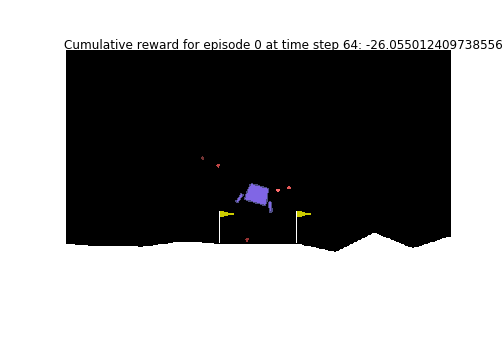
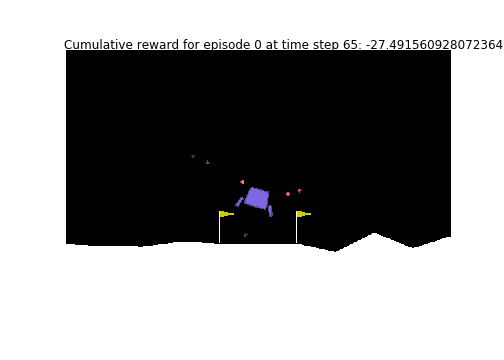
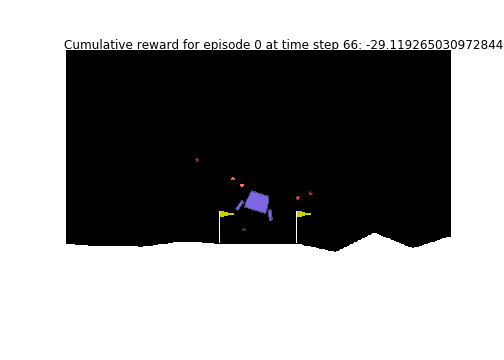
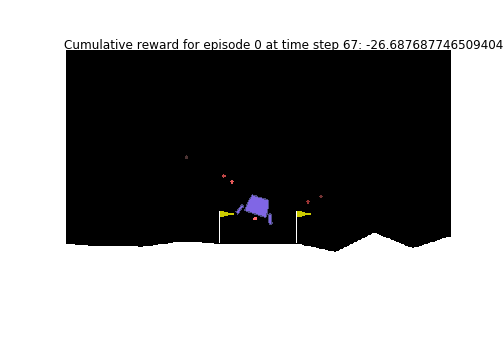
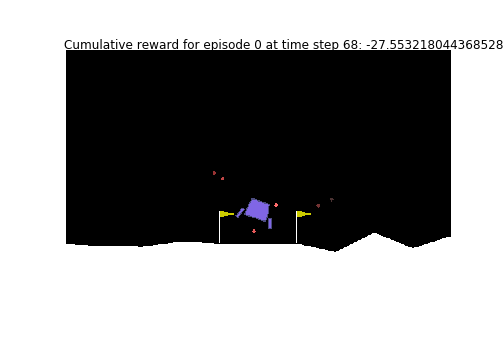
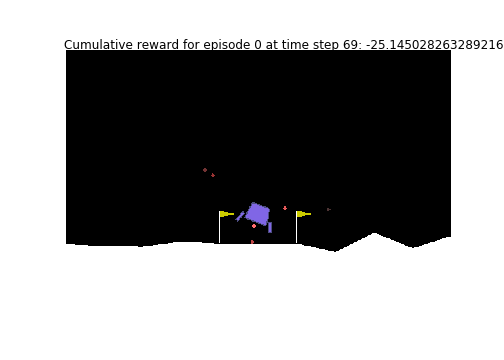
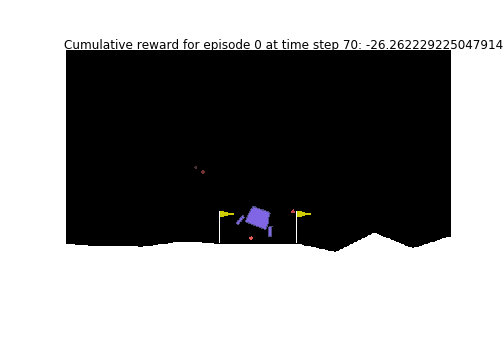
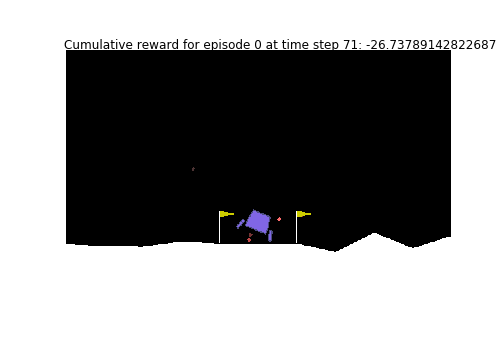
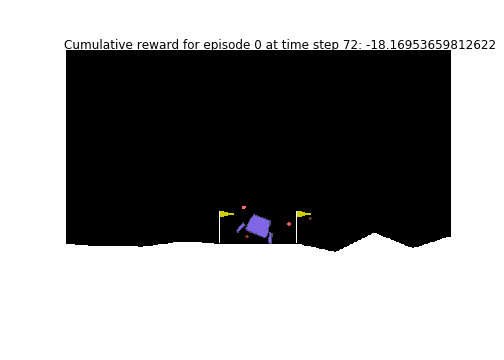
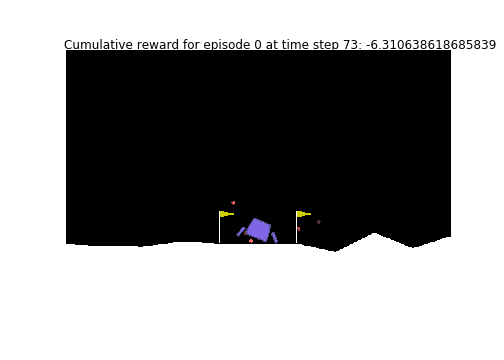

In [12]:
e.test(a)

# CartPole 

In [8]:
env = gym.make("CartPole-v0")
e = EnvRunner(env)

# Lunar Lander Actor Critic (TD learning)

In [9]:
env = gym.make("LunarLander-v2")
e = EnvRunner(env)

## Tensorflow

In [10]:
a = ActorCriticTf(estimator=DualPolicyValueHeadTf,learning_rate=0.001)

In [11]:
stats = e.train(a,episodes=2500,train_episodal=False)

  0%|          | 0/2500 [00:00<?, ?it/s]

Model Created!


InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Sub]

In [ ]:
e.test(a)

### Pytorch

In [ ]:
class DualPolicyValueHeadTorch(torch.nn.Module):
    def __init__(self,input_space,output_space,configs={}):
        super(DualPolicyValueHeadTorch, self).__init__()
        value = []
        #value head
        value.append(create_linear_torch(input_dims=input_space[0],output_dims=1,relu=False))
        self.valuehead = torch.nn.Sequential(*value)
        #policy head
        policy = []
        policy.append(create_linear_torch(input_dims=input_space[0],output_dims=output_space,relu=False))
        self.policyhead = torch.nn.Sequential(*policy)        
        if "softmax" in configs:
            self.policyhead = torch.nn.Sequential(*[self.policyhead,torch.nn.Softmax(dim=-1)])
        
    def forward(self,x):
        value = self.valuehead(x)
        policy = self.policyhead(x)
        return value, policy

In [ ]:
a = DualPolicyValueHeadTorch([4],2)